<a href="https://colab.research.google.com/github/goguaD/finalProjectML/blob/main/N-BEATS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
import os
import json
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

In [3]:
print("Mounting Google Drive...")
drive.mount('/content/drive')

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ditogogua","key":"65a423eed3ea99d51a9c7348b802e85b"}'}

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle competitions list | head -5

ref                                                                              deadline             category                reward  teamCount  userHasEntered  
-------------------------------------------------------------------------------  -------------------  ---------------  -------------  ---------  --------------  
https://www.kaggle.com/competitions/arc-prize-2025                               2025-11-03 23:59:00  Featured         1,000,000 Usd        613           False  
https://www.kaggle.com/competitions/google-gemma-3n-hackathon                    2025-08-06 23:59:00  Featured           150,000 Usd          0           False  
https://www.kaggle.com/competitions/make-data-count-finding-data-references      2025-09-09 23:59:00  Research           100,000 Usd        495           False  


In [8]:
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting

walmart-recruiting-store-sales-forecasting.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
with zipfile.ZipFile('walmart-recruiting-store-sales-forecasting.zip', 'r') as zip_ref:
    zip_ref.extractall('walmart_data')

print("Extracted files:")
for root, dirs, files in os.walk('walmart_data'):
    for file in files:
        print(os.path.join(root, file))

Extracted files:
walmart_data/test.csv.zip
walmart_data/features.csv.zip
walmart_data/sampleSubmission.csv.zip
walmart_data/stores.csv
walmart_data/train.csv.zip


In [10]:
train_df = pd.read_csv('walmart_data/train.csv.zip')
test_df = pd.read_csv('walmart_data/test.csv.zip')
features_df = pd.read_csv('walmart_data/features.csv.zip')
stores_df = pd.read_csv('walmart_data/stores.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"Features shape: {features_df.shape}")
print(f"Stores shape: {stores_df.shape}")

print("\nTrain data info:")
print(train_df.head())
print("\nTrain data types:")
print(train_df.dtypes)
print("\nMissing values:")
print(train_df.isnull().sum())

Train shape: (421570, 5)
Test shape: (115064, 4)
Features shape: (8190, 12)
Stores shape: (45, 3)

Train data info:
   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False

Train data types:
Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
dtype: object

Missing values:
Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64


In [16]:
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])
features_df['Date'] = pd.to_datetime(features_df['Date'])

print("Checking IsHoliday columns:")
print(f"IsHoliday in train_df: {'IsHoliday' in train_df.columns}")
print(f"IsHoliday in test_df: {'IsHoliday' in test_df.columns}")
print(f"IsHoliday in features_df: {'IsHoliday' in features_df.columns}")

print("Merging datasets...")
train_full = train_df.merge(features_df, on=['Store', 'Date'], how='left', suffixes=('', '_feat'))
train_full = train_full.merge(stores_df, on='Store', how='left')

test_full = test_df.merge(features_df, on=['Store', 'Date'], how='left', suffixes=('', '_feat'))
test_full = test_full.merge(stores_df, on='Store', how='left')

def fix_isholiday_column(df):
    if 'IsHoliday' in df.columns and 'IsHoliday_feat' in df.columns:
        df['IsHoliday'] = df['IsHoliday'].fillna(df['IsHoliday_feat'])
        df = df.drop('IsHoliday_feat', axis=1)
    elif 'IsHoliday_x' in df.columns and 'IsHoliday_y' in df.columns:
        df['IsHoliday'] = df['IsHoliday_x'].fillna(df['IsHoliday_y'])
        df = df.drop(['IsHoliday_x', 'IsHoliday_y'], axis=1)
    elif 'IsHoliday_feat' in df.columns and 'IsHoliday' not in df.columns:
        df['IsHoliday'] = df['IsHoliday_feat']
        df = df.drop('IsHoliday_feat', axis=1)

    return df

train_full = fix_isholiday_column(train_full)
test_full = fix_isholiday_column(test_full)

print("Columns after merge:")
print(f"Train columns: {train_full.columns.tolist()}")
print(f"IsHoliday in train_full: {'IsHoliday' in train_full.columns}")

print("Handling missing values...")
train_full = train_full.fillna(0)
test_full = test_full.fillna(0)

def extract_date_features(df):
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['DayOfYear'] = df['Date'].dt.dayofyear
    df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)
    return df

train_full = extract_date_features(train_full)
test_full = extract_date_features(test_full)

le_type = LabelEncoder()
train_full['Type_encoded'] = le_type.fit_transform(train_full['Type'])
test_full['Type_encoded'] = le_type.transform(test_full['Type'])

print("Data preprocessing completed!")
print(f"Final train_full shape: {train_full.shape}")
print(f"IsHoliday column exists: {'IsHoliday' in train_full.columns}")

Checking IsHoliday columns:
IsHoliday in train_df: True
IsHoliday in test_df: True
IsHoliday in features_df: True
Merging datasets...
Columns after merge:
Train columns: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size']
IsHoliday in train_full: True
Handling missing values...
Data preprocessing completed!
Final train_full shape: (421570, 24)
IsHoliday column exists: True


In [17]:
def wmae(y_true, y_pred, weights):
    """
    Calculate Weighted Mean Absolute Error (WMAE)

    Parameters:
    y_true: actual values
    y_pred: predicted values
    weights: weights for each observation

    Returns:
    wmae_score: weighted mean absolute error
    """
    if len(y_true) != len(y_pred) or len(y_true) != len(weights):
        raise ValueError("Arrays must have the same length")

    abs_errors = np.abs(y_true - y_pred)

    weighted_errors = abs_errors * weights

    wmae_score = np.sum(weighted_errors) / np.sum(weights)

    return wmae_score

In [18]:
class NBeatsBlock(nn.Module):
    def __init__(self, input_size, theta_size, basis_function, layers, layer_size):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(input_size, layer_size)] +
                                   [nn.Linear(layer_size, layer_size) for _ in range(layers-1)])
        self.basis_function = basis_function
        self.theta_layer = nn.Linear(layer_size, theta_size)

    def forward(self, x):
        for layer in self.layers:
            x = torch.relu(layer(x))
        theta = self.theta_layer(x)
        return self.basis_function(theta)

class GenericBasis(nn.Module):
    def __init__(self, backcast_size, forecast_size):
        super().__init__()
        self.backcast_size = backcast_size
        self.forecast_size = forecast_size

    def forward(self, theta):
        backcast = theta[:, :self.backcast_size]
        forecast = theta[:, self.backcast_size:]
        return backcast, forecast

class NBeatsModel(nn.Module):
    def __init__(self, input_size, forecast_size, n_blocks=3, layers=4, layer_size=512):
        super().__init__()
        self.input_size = input_size
        self.forecast_size = forecast_size
        self.n_blocks = n_blocks

        self.blocks = nn.ModuleList()
        for i in range(n_blocks):
            basis_function = GenericBasis(input_size, forecast_size)
            theta_size = input_size + forecast_size
            block = NBeatsBlock(input_size, theta_size, basis_function, layers, layer_size)
            self.blocks.append(block)

    def forward(self, x):
        residuals = x
        forecasts = []

        for block in self.blocks:
            backcast, forecast = block(residuals)
            residuals = residuals - backcast
            forecasts.append(forecast)

        return torch.stack(forecasts, dim=1).sum(dim=1)

In [19]:
class WalmartDataset(Dataset):
    def __init__(self, data, sequence_length=52, forecast_length=1):
        self.data = data
        self.sequence_length = sequence_length
        self.forecast_length = forecast_length

        self.sequences = []
        self.targets = []
        self.weights = []

        print(f"Creating sequences from {len(data)} records...")

        for (store, dept), group in data.groupby(['Store', 'Dept']):
            group = group.sort_values('Date')
            sales = group['Weekly_Sales'].values

            if 'IsHoliday' in group.columns:
                is_holiday = group['IsHoliday'].values
            else:
                print("Warning: IsHoliday column not found, using default weights")
                is_holiday = np.zeros(len(sales))

            for i in range(len(sales) - sequence_length - forecast_length + 1):
                seq = sales[i:i+sequence_length]
                target = sales[i+sequence_length:i+sequence_length+forecast_length]

                if i+sequence_length < len(is_holiday):
                    weight = 5 if is_holiday[i+sequence_length] else 1
                else:
                    weight = 1

                self.sequences.append(seq)
                self.targets.append(target)
                self.weights.append(weight)

        self.sequences = np.array(self.sequences)
        self.targets = np.array(self.targets)
        self.weights = np.array(self.weights)

        print(f"Created {len(self.sequences)} sequences")

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return (torch.FloatTensor(self.sequences[idx]),
                torch.FloatTensor(self.targets[idx]),
                torch.FloatTensor([self.weights[idx]]))

In [20]:
SEQUENCE_LENGTH = 52
FORECAST_LENGTH = 1
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 50

print("Creating dataset...")
train_dataset = WalmartDataset(train_full, SEQUENCE_LENGTH, FORECAST_LENGTH)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Dataset created with {len(train_dataset)} samples")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = NBeatsModel(
    input_size=SEQUENCE_LENGTH,
    forecast_size=FORECAST_LENGTH,
    n_blocks=3,
    layers=4,
    layer_size=256
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
SEQUENCE_LENGTH = 52
FORECAST_LENGTH = 1
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 50

print("Creating dataset...")
train_dataset = WalmartDataset(train_full, SEQUENCE_LENGTH, FORECAST_LENGTH)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Dataset created with {len(train_dataset)} samples")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = NBeatsModel(
    input_size=SEQUENCE_LENGTH,
    forecast_size=FORECAST_LENGTH,
    n_blocks=3,
    layers=4,
    layer_size=256
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


Creating dataset...
Creating sequences from 421570 records...
Created 261083 sequences
Dataset created with 261083 samples
Using device: cuda
Creating dataset...
Creating sequences from 421570 records...
Created 261083 sequences
Dataset created with 261083 samples
Using device: cuda


In [21]:
train_losses = []
wmae_scores = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    all_preds = []
    all_targets = []
    all_weights = []

    for batch_idx, (sequences, targets, weights) in enumerate(train_loader):
        sequences = sequences.to(device)
        targets = targets.to(device)
        weights = weights.to(device)

        optimizer.zero_grad()

        predictions = model(sequences)
        loss = criterion(predictions, targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        all_preds.extend(predictions.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())
        all_weights.extend(weights.detach().cpu().numpy())

    all_preds = np.array(all_preds).flatten()
    all_targets = np.array(all_targets).flatten()
    all_weights = np.array(all_weights).flatten()

    wmae_score = wmae(all_targets, all_preds, all_weights)

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    wmae_scores.append(wmae_score)

    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{EPOCHS}], Loss: {avg_loss:.4f}, WMAE: {wmae_score:.4f}')

print("Training completed!")


Epoch [0/50], Loss: 16881318.4957, WMAE: 1914.7935
Epoch [10/50], Loss: 7992067.5398, WMAE: 1444.7357
Epoch [20/50], Loss: 6528916.2746, WMAE: 1353.3997
Epoch [30/50], Loss: 6011332.9907, WMAE: 1299.6853
Epoch [40/50], Loss: 5304110.1535, WMAE: 1254.7673
Training completed!


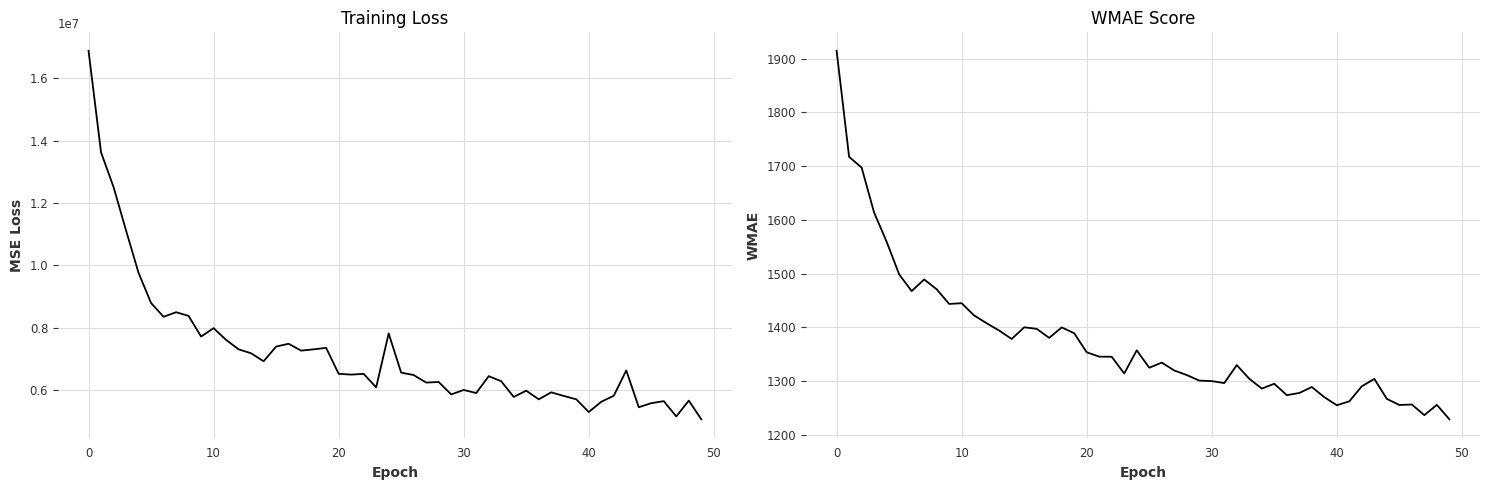

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses)
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE Loss')

ax2.plot(wmae_scores)
ax2.set_title('WMAE Score')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('WMAE')

plt.tight_layout()
plt.show()


In [23]:
print("\nFinal Model Performance:")
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final WMAE Score: {wmae_scores[-1]:.4f}")


Final Model Performance:
Final Training Loss: 5071090.4450
Final WMAE Score: 1228.6083


In [24]:
print("\nGenerating sample predictions...")

model.eval()
with torch.no_grad():
    sample_sequences, sample_targets, sample_weights = next(iter(train_loader))
    sample_sequences = sample_sequences.to(device)

    sample_predictions = model(sample_sequences)

    sample_wmae = wmae(
        sample_targets.numpy().flatten(),
        sample_predictions.cpu().numpy().flatten(),
        sample_weights.numpy().flatten()
    )

    print(f"Sample WMAE: {sample_wmae:.4f}")



Generating sample predictions...
Sample WMAE: 1419.6023


In [27]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.2/196.2 kB 22.0 MB/s eta 0:00:00


In [28]:
import mlflow
import os

os.environ["MLFLOW_TRACKING_USERNAME"] = "goguaD"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "685c4f5b2a0c555f9136c60a8666661d952de9be"
mlflow.set_tracking_uri("https://dagshub.com/goguaD/finalProjectML.mlflow")
mlflow.set_experiment("walmart-sales")

with mlflow.start_run():
    mlflow.log_param("model", "N-BEATS")
    mlflow.log_param("sequence_length", 52)
    mlflow.log_param("epochs", 50)
    mlflow.log_param("learning_rate", 0.001)

    mlflow.log_metric("final_wmae", sample_wmae)


    print("Logged successfully!")

Logged successfully!
🏃 View run placid-donkey-294 at: https://dagshub.com/goguaD/finalProjectML.mlflow/#/experiments/0/runs/140695c2377a4a30a0ae1fff1e7dfdbf
🧪 View experiment at: https://dagshub.com/goguaD/finalProjectML.mlflow/#/experiments/0


In [29]:
mlflow.end_run()